In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import category_encoders as ce
import random 
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

# Importing models
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### I can summarize the steps followed throughout this project as the following:
1. Loading and initial insights and data cleaning
2. Data analysis
3. Feature engineering
4. Categorical encoding
5. Modelling and evaluation
6. Dealing with classes within features
7. Re-Modelling
8. Conclusions
9. Appendix: extra tests

## 1. Loading and initial insights from the data

In [2]:
df = pd.read_csv('flavors_of_cacao.csv',delimiter=",",low_memory=False,na_values=[' ','NA','NaN',' NA'])

In [3]:
df.info() 
# I made a quick manual correction in the header of the original Dataset by removing unnecessary returns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Company (Maker-if known)          1795 non-null   object 
 1   Specific Bean Origin or Bar Name  1795 non-null   object 
 2   REF                               1795 non-null   int64  
 3   Review Date                       1795 non-null   int64  
 4   Cocoa Percent                     1795 non-null   object 
 5   Company Location                  1795 non-null   object 
 6   Rating                            1795 non-null   float64
 7   Bean Type                         1794 non-null   object 
 8   Broad Bean Origin                 1794 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 126.3+ KB


In [4]:
df.shape

(1795, 9)

In [5]:
df

,Company (Maker-if known),Specific Bean Origin or Bar Name,REF,Review Date,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru
...,...,...,...,...,...,...,...,...,...
1790,Zotter,Peru,647,2011,70%,Austria,3.75,,Peru
1791,Zotter,Congo,749,2011,65%,Austria,3.00,Forastero,Congo
1792,Zotter,Kerala State,749,2011,65%,Austria,3.50,Forastero,India
1793,Zotter,Kerala State,781,2011,62%,Austria,3.25,,India


### Just by looking at the table above, we can see that there are several Empty values that we will have to deal with.

In [6]:
df.columns

Index(['Company (Maker-if known)', 'Specific Bean Origin or Bar Name', 'REF',
       'Review Date', 'Cocoa Percent', 'Company Location', 'Rating',
       'Bean Type', 'Broad Bean Origin'],
      dtype='object')

#### Only 1795 rows, it is not much, so we have to bear it in mind.

In [7]:
column_names = df.columns.tolist()
column_names[0]='Company'
column_names[1]='Specific_Bean_Origin_or_Bar_Name'
column_names[3] = 'Review_Date'
column_names[4] = 'Cocoa_Percent'
column_names[5] = 'Company_Location'
column_names[-2] = 'Bean_Type'
column_names[-1] = 'Broad_Bean_Origin'

df.columns = column_names

#### Columns information:
- Company (Maker-if known) = Name of the company manufacturing the bar
- Specific Bean Origin\nor Bar Name = The specific geo-region of origin for the bar
- #REF = A value linked to when the review was entered in the database. Higher = more recent
- Review Date = Date of publication of the review
- Cocoa Percent = Cocoa percentage (darkness) of the chocolate bar being reviewed
- Company Location = Manufacturer base country
- Rating = Expert rating for the bar
- Bean Type = The variety (breed) of bean used, if provided
- Broad Bean Origin = The broad geo-region of origin for the bean

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
REF,1795.0,1035.904735,552.886365,5.0,576.000,1069.00,1502.0,1952.0
Review_Date,1795.0,2012.325348,2.927210,2006.0,2010.000,2013.00,2015.0,2017.0
Rating,1795.0,3.185933,0.478062,1.0,2.875,3.25,3.5,5.0


In [9]:
np.sum(df.isnull())

Company                             0
Specific_Bean_Origin_or_Bar_Name    0
REF                                 0
Review_Date                         0
Cocoa_Percent                       0
Company_Location                    0
Rating                              0
Bean_Type                           1
Broad_Bean_Origin                   1
dtype: int64

### As expected, the isnull or isna tasks were not able to count the empty values, so we will have to clean and solve it before our analysis. In this case, I am not just substituing them, I am creating a new class within these features and calling them "unknown" simply because we don't have much information about them.

In [10]:
# Here I am creating a new input for the empty values, by just substituing this Category variables by "Unknown".

empty_value = df["Bean_Type"].values[0]
def replace_nan(value):
    """
    This function basically identify empty values and substitute them for a new class that I am calling Unknown
    """
    if value == empty_value:
        return "Unknown"
    else:
        return value
for col in df.columns:
    if df[col].dtype == 'O':
        df[col] = df[col].apply(lambda value: replace_nan(value))

In [11]:
df

,Company,Specific_Bean_Origin_or_Bar_Name,REF,Review_Date,Cocoa_Percent,Company_Location,Rating,Bean_Type,Broad_Bean_Origin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,Unknown,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,Unknown,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,Unknown,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,Unknown,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,Unknown,Peru
...,...,...,...,...,...,...,...,...,...
1790,Zotter,Peru,647,2011,70%,Austria,3.75,Unknown,Peru
1791,Zotter,Congo,749,2011,65%,Austria,3.00,Forastero,Congo
1792,Zotter,Kerala State,749,2011,65%,Austria,3.50,Forastero,India
1793,Zotter,Kerala State,781,2011,62%,Austria,3.25,Unknown,India


In [12]:
# Counting the amount of Unknown
unknown_counts = (df == "Unknown").sum()
# Display the count of "Unknown" in each column
print(unknown_counts)

Company                               0
Specific_Bean_Origin_or_Bar_Name      0
REF                                   0
Review_Date                           0
Cocoa_Percent                         0
Company_Location                      0
Rating                                0
Bean_Type                           887
Broad_Bean_Origin                    73
dtype: int64


### Bean Type (887) and Broad Bean Origin (73) show NaN values. Which basically means that Bean_Type has almost 49.5% of missing data, so it doesn't make much sense to remove these features, specially because we don't have many features available for these dataset. Therefore, as I previously mentioned, I created a new class called "Unknown" to account for the missing data.

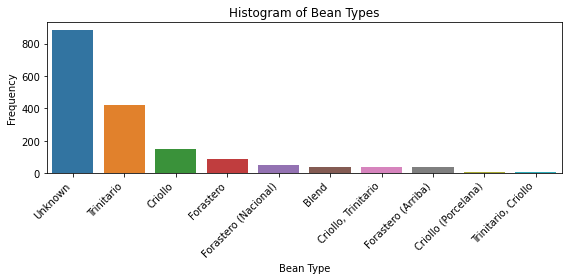

In [13]:
bean_type_15 = df.Bean_Type.value_counts().head(10)

# Plot histogram using seaborn
plt.figure(figsize=(8, 4))
ax = sns.barplot(x=bean_type_15.index, y=bean_type_15.values)
ax.set(xlabel='Bean Type', ylabel='Frequency', title='Histogram of Bean Types')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Ensure labels are properly displayed
plt.show()  # Show the plot

In [14]:
df.isnull().sum() # BUT there is indeed values marked as NaN or Null still.

Company                             0
Specific_Bean_Origin_or_Bar_Name    0
REF                                 0
Review_Date                         0
Cocoa_Percent                       0
Company_Location                    0
Rating                              0
Bean_Type                           1
Broad_Bean_Origin                   1
dtype: int64

In [15]:
# I could just drop these two rows (if they are different), it would not affect either way the model but 
# I will replace NaN by Unknown for this feature.
df = df.fillna("Unknown")

# If I were to drop this line, I would just use this command bellow:
#df=df.dropna()

In [16]:
df['Cocoa_Percent'] = df['Cocoa_Percent'].str.replace('%', '').astype('float64') # Removing the % symbol from this 

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Company                           1795 non-null   object 
 1   Specific_Bean_Origin_or_Bar_Name  1795 non-null   object 
 2   REF                               1795 non-null   int64  
 3   Review_Date                       1795 non-null   int64  
 4   Cocoa_Percent                     1795 non-null   float64
 5   Company_Location                  1795 non-null   object 
 6   Rating                            1795 non-null   float64
 7   Bean_Type                         1795 non-null   object 
 8   Broad_Bean_Origin                 1795 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 126.3+ KB


In [18]:
df

,Company,Specific_Bean_Origin_or_Bar_Name,REF,Review_Date,Cocoa_Percent,Company_Location,Rating,Bean_Type,Broad_Bean_Origin
0,A. Morin,Agua Grande,1876,2016,63.0,France,3.75,Unknown,Sao Tome
1,A. Morin,Kpime,1676,2015,70.0,France,2.75,Unknown,Togo
2,A. Morin,Atsane,1676,2015,70.0,France,3.00,Unknown,Togo
3,A. Morin,Akata,1680,2015,70.0,France,3.50,Unknown,Togo
4,A. Morin,Quilla,1704,2015,70.0,France,3.50,Unknown,Peru
...,...,...,...,...,...,...,...,...,...
1790,Zotter,Peru,647,2011,70.0,Austria,3.75,Unknown,Peru
1791,Zotter,Congo,749,2011,65.0,Austria,3.00,Forastero,Congo
1792,Zotter,Kerala State,749,2011,65.0,Austria,3.50,Forastero,India
1793,Zotter,Kerala State,781,2011,62.0,Austria,3.25,Unknown,India


In [19]:
# Check for duplicates in the DataFrame
duplicates = df.duplicated()

# Print the number of duplicates found
print("Number of duplicates:", duplicates.sum())

# Print the duplicate rows, if any
if duplicates.any():
    duplicate_rows = df[duplicates]
    print("Duplicate rows:")
    print(duplicate_rows)
else:
    print("No duplicates found.")

Number of duplicates: 0
No duplicates found.


#### Therefore, this dataset contains no duplicates. 

## 2. Data Analysis

### The goal of this section here is basically to get some insights on the data, therefore, I want to answer questions like: 
- What are the best rated companies, countries, cocoa percentage?
- Is there a correlation between the features?
- What is the relation between years and ratings?

In [20]:
df.nunique()

Company                              416
Specific_Bean_Origin_or_Bar_Name    1039
REF                                  440
Review_Date                           12
Cocoa_Percent                         45
Company_Location                      60
Rating                                13
Bean_Type                             41
Broad_Bean_Origin                    100
dtype: int64

In [21]:
# Let's take a look at the data we want to infer/predict: rating
df.Rating.unique()

array([3.75, 2.75, 3.  , 3.5 , 4.  , 3.25, 2.5 , 5.  , 1.75, 1.5 , 2.25,
       2.  , 1.  ])

In [22]:
df.Rating.value_counts()

3.50    392
3.00    341
3.25    303
2.75    259
3.75    210
2.50    127
4.00     98
2.00     32
2.25     14
1.50     10
1.00      4
1.75      3
5.00      2
Name: Rating, dtype: int64

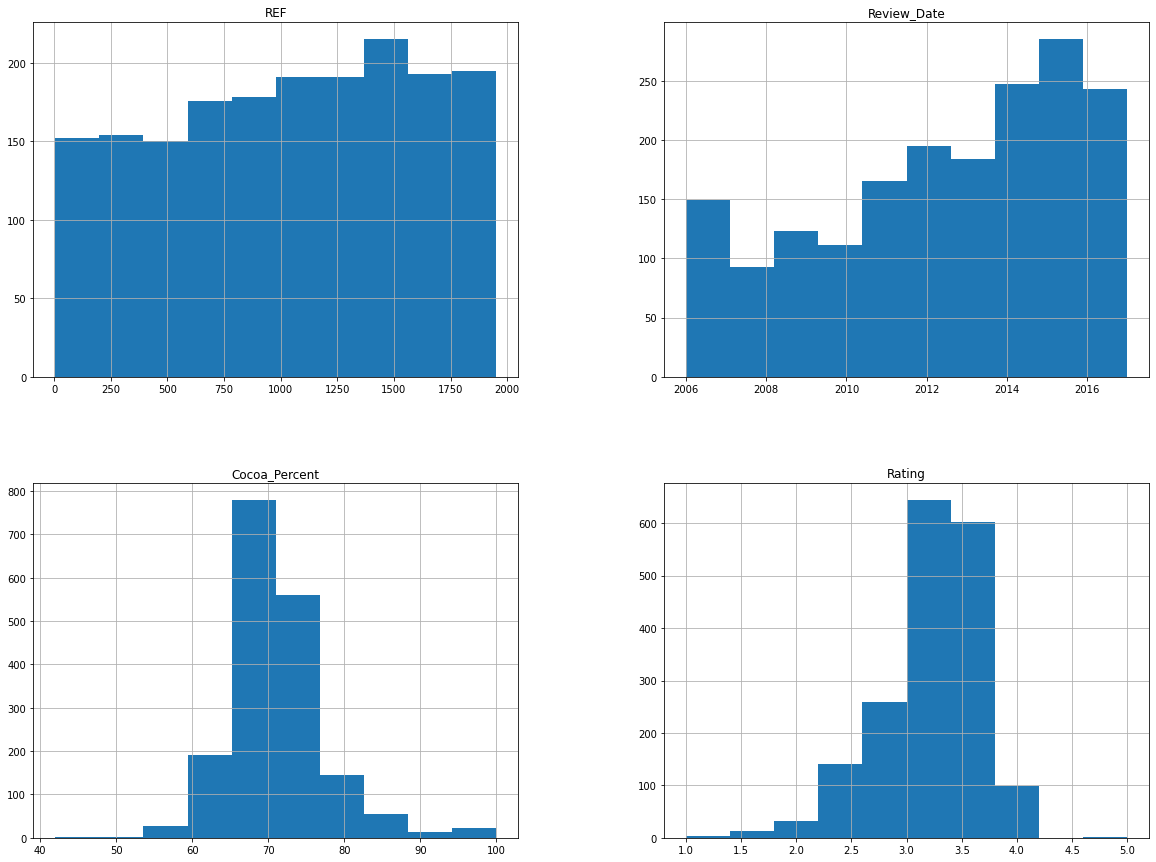

In [23]:
%matplotlib inline
df.hist(bins=10,figsize=(20,15))
plt.show()

### The distribution of shapes almost follows a gaussian profile with a tail towards low ratings and high Cocoa Percent, for example.

<AxesSubplot:ylabel='Cocoa_Percent'>

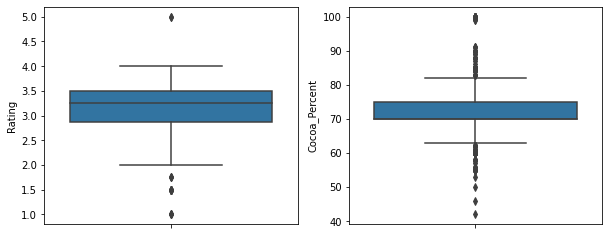

In [24]:
f, axes = plt.subplots(ncols=2, figsize=(10,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(y="Rating", data=df, ax=axes[0])
sns.boxplot(y="Cocoa_Percent", data=df, ax=axes[1])

#### There are few outliers in the Rating and cocoa_percent as can be seen above. 
#### Moreover, what is the relation between Cocoa Percentage and Rating? What is the favorite percentage of Cocoa from people according to the ratings?

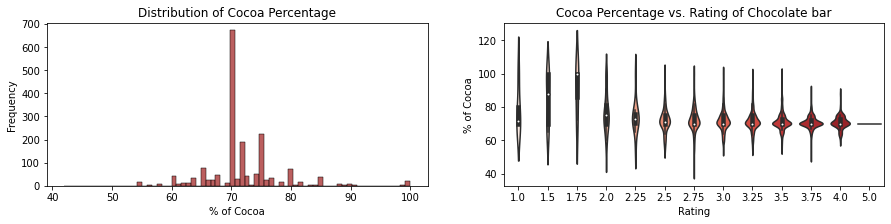

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(15,3))

# Distribution of Cocoa Percentage histogram
sns.histplot(df.Cocoa_Percent, kde=False, color="brown", ax=ax[0])
ax[0].set_xlabel("% of Cocoa")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Distribution of Cocoa Percentage")

# Cocoa Percentage vs Rating
sns.violinplot(x=df.Rating, y=df.Cocoa_Percent, ax=ax[1], palette="Reds")
ax[1].set_ylabel("% of Cocoa")
ax[1].set_xlabel("Rating")
ax[1].set_title("Cocoa Percentage vs. Rating of Chocolate bar")
plt.show()

#### Importants results: Most of the chocolate from this data base is contains around 70% of Cocoa, and we can also see that they are the highest ratings are also towards this percentage of Cocoa.

#### Let's check whether there is a relation between the dates and the Ratings, for instance, if the ratings increased by year or where they are most concentrated.

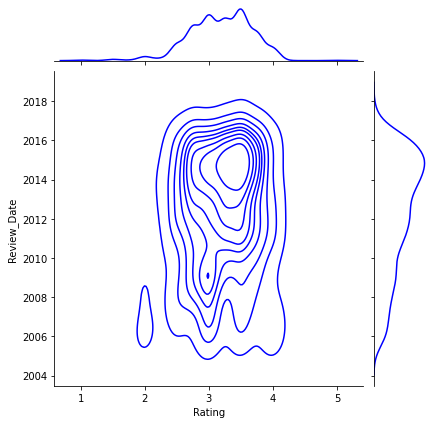

In [26]:
sns.jointplot(x='Rating',y='Review_Date', data=df, color='blue',kind='kde')

#### Ratings did not increase by year, but the majority of ratings 3.0-3.5 were given around 2014 and 2016. Curiously, there is a window from 2006 to 2008 that shows a good amount of ratings 2.

#### Let's now take a look at the companies that produce these chocolate bars. 

In [27]:
# Let's take a look at the companies
df.Company.value_counts() # Let's also remember that we have 416 unique companies in this dataset

# Natural question emerge: what are the best rated companies?

Soma                                   47
Bonnat                                 27
Fresco                                 26
Pralus                                 25
A. Morin                               23
                                       ..
Friis Holm                              1
Oakland Chocolate Co.                   1
Artisan du Chocolat (Casa Luker)        1
Heirloom Cacao Preservation (Mindo)     1
Chuao Chocolatier (Pralus)              1
Name: Company, Length: 416, dtype: int64

In [28]:
# First we have to group by the Company, compute the average Rating
companies = df.groupby('Company').mean()['Rating']
companies.sort_values(ascending = False).round(3)

Company
Tobago Estate (Pralus)                  4.000
Heirloom Cacao Preservation (Zokoko)    3.875
Ocelot                                  3.875
Amedei                                  3.846
Matale                                  3.812
                                        ...  
Jacque Torres                           2.000
Love Bar                                2.000
Callebaut                               1.875
Machu Picchu Trading Co.                1.875
Cote d' Or (Kraft)                      1.000
Name: Rating, Length: 416, dtype: float64

<AxesSubplot:title={'center':'Companies with higher ratings'}, ylabel='Company'>

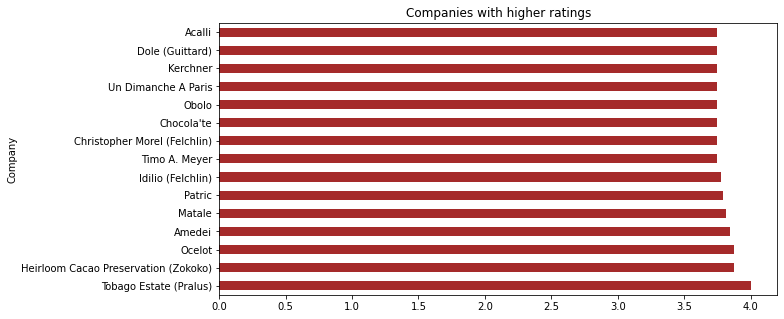

In [29]:
company_list = companies.sort_values(ascending=False).round(3).head(15)
company_list.index
company_list.plot(kind = 'barh', figsize = (10, 5),title = 'Companies with higher ratings',color='brown')

In [30]:
company_list.index

Index(['Tobago Estate (Pralus)', 'Heirloom Cacao Preservation (Zokoko)',
       'Ocelot', 'Amedei', 'Matale', 'Patric', 'Idilio (Felchlin)',
       'Timo A. Meyer', 'Christopher Morel (Felchlin)', 'Chocola'te', 'Obolo',
       'Un Dimanche A Paris', 'Kerchner', 'Dole (Guittard)', 'Acalli'],
      dtype='object', name='Company')

In [31]:
top_15_companies = list(company_list.index)

In [32]:
df.query('Company in @top_15_companies')
best_companies= df.query('Company in @top_15_companies')
best_companies.shape

(49, 9)

In [33]:
best_companies.groupby('Company_Location')['Company'].nunique().sort_values(ascending = False)

Company_Location
U.S.A.         6
France         2
Switzerland    1
Scotland       1
Italy          1
Germany        1
Chile          1
Canada         1
Australia      1
Name: Company, dtype: int64

#### Countries with the highest ratings are those listed above. In particular, the USA has 6 companies among the 15 with the highest ratings.

In [34]:
best_companies.Cocoa_Percent.value_counts()

70.0    24
72.0    11
68.0     4
75.0     3
67.0     2
74.0     2
63.0     2
66.0     1
Name: Cocoa_Percent, dtype: int64

#### That's just a confirmation on what we discussed earlier, the best rated Chocolates are mainly the ones with 70% and 72% of Cocoa, even for these top companies.

In [35]:
best_companies.Bean_Type.value_counts()

Trinitario                  17
Criollo                     10
Unknown                      9
Blend                        5
Trinitario (85% Criollo)     2
Amazon, ICS                  1
Beniano                      1
Trinitario, TCGA             1
Criollo (Porcelana)          1
Forastero (Nacional)         1
Forastero                    1
Name: Bean_Type, dtype: int64

#### Furthermore: the best rated Chocolates are made mainly from beans known as Trinitario and Criollo

In [ ]:
best_companies.Broad_Bean_Origin.value_counts()

#### Bean Origin from the chocolate with best ratings is by far from Venezuela.

In [37]:
best_companies.Company.value_counts()

Amedei                                  13
Idilio (Felchlin)                       10
Patric                                   6
Matale                                   4
Ocelot                                   2
Obolo                                    2
Chocola'te                               2
Heirloom Cacao Preservation (Zokoko)     2
Acalli                                   2
Timo A. Meyer                            1
Tobago Estate (Pralus)                   1
Un Dimanche A Paris                      1
Dole (Guittard)                          1
Christopher Morel (Felchlin)             1
Kerchner                                 1
Name: Company, dtype: int64

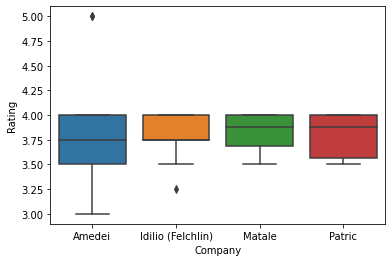

In [38]:
sns.boxplot(x='Company',y='Rating',data=df.query('Company==("Amedei","Idilio (Felchlin)","Patric","Matale")'));

#### Companies with the best ratings are Amedei and Idilio (Felchlin). One of the outliers (rating 5) is on Amedei.

### Outliers analysis on Rating and Cocoa Percentage

In [39]:
# How many data we have that shows very high Rating?
df[df['Rating']>4.0]

,Company,Specific_Bean_Origin_or_Bar_Name,REF,Review_Date,Cocoa_Percent,Company_Location,Rating,Bean_Type,Broad_Bean_Origin
78,Amedei,Chuao,111,2007,70.0,Italy,5.0,Trinitario,Venezuela
86,Amedei,Toscano Black,40,2006,70.0,Italy,5.0,Blend,Unknown


#### People like Amedei. Do remember that Amedei has 13 ratings and 2 of them are the highest. Interesting!

In [40]:
# How many data we have that shows very low Rating?
df[df['Rating']<1.5]

,Company,Specific_Bean_Origin_or_Bar_Name,REF,Review_Date,Cocoa_Percent,Company_Location,Rating,Bean_Type,Broad_Bean_Origin
326,Callebaut,Baking,141,2007,70.0,Belgium,1.0,Unknown,Ecuador
437,Claudio Corallo,Principe,252,2008,100.0,Sao Tome,1.0,Forastero,Sao Tome & Principe
465,Cote d' Or (Kraft),Sensations Intense,48,2006,70.0,Belgium,1.0,Unknown,Unknown
1175,Neuhaus (Callebaut),Dark,135,2007,73.0,Belgium,1.0,Unknown,Unknown


#### I found funny that 3 of the 4 lowest ratings are from Belgium, even though Belgium chocolates are well known worldwide. Also, surprisingly, they have Cocoa Percentage of 70% which usually shows the highest ratings.

#### I believe this Data Analysis part gave us some nice insights on the data and what the outliers are. Now, let's move on to the part that we have to get concern before modelling this data. It is important to see whether there are features correlated or not.

In [41]:
corr = df.corr()
corr

,REF,Review_Date,Cocoa_Percent,Rating
REF,1.000000,0.985076,0.037791,0.101030
Review_Date,0.985076,1.000000,0.038177,0.099846
Cocoa_Percent,0.037791,0.038177,1.000000,-0.164820
Rating,0.101030,0.099846,-0.164820,1.000000


In [42]:
corr["Rating"].sort_values(ascending=False)

Rating           1.000000
REF              0.101030
Review_Date      0.099846
Cocoa_Percent   -0.164820
Name: Rating, dtype: float64

#### There is a small anti-correlation with the Cocoa_Percent feature (only -0.16). 

Text(0.5, 1.0, 'Correlation Map')

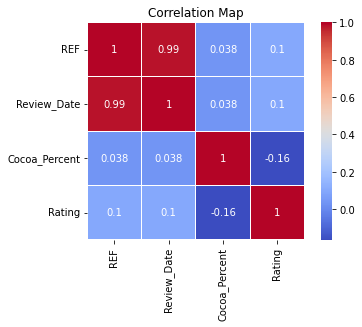

In [43]:
sns.heatmap(df.corr(), linewidths=0.1, vmax=1.0, square=True, cmap='coolwarm', linecolor='white', annot=True).set_title("Correlation Map")

#### Also, we can see a high correlation between REF and Review Date, which, in my interpretation is very much expected. We can perhaps do some feature engineering to work on them.

### <b>3. Feature Engineering</b>

#### Based on the information we observed, the features "REF" and "Review_Date" have a Pearson correlation coefficient of 0.99. A correlation coefficient of 0.99 indicates a very strong positive linear relationship between the two features.

#### Since the correlation between these features is very high, it suggests that they provide similar information and may be redundant in our analysis here. In such cases, it is better to perform feature engineering to reduce multicollinearity and improve the model's performance.

#### What I am doing here:
- Instead of using the exact values of "REF" and "Review_Date", I will extract more meaningful information from them. I will try to derive new features such as the year from the "Review_Date" or calculate the time difference between the review date and a reference date. These new features may provide more valuable insights to our model in the future.

In [44]:
def time_diff(df):
    # Convert 'Review_Date' column to datetime
    df['Review_Date'] = pd.to_datetime(df['Review_Date'], format='%Y')

    # Here I am defining a reference date
    reference_date = pd.to_datetime('2000', format='%Y')

    # Creating a new feature 'Time_Difference' as the time difference between 'Review_Date' and the reference date
    df['Time_Difference'] = (df['Review_Date'] - reference_date).dt.total_seconds() / (60 * 60 * 24 * 365.25)

    # Drop the original 'REF' and 'Review_Date' columns as they are now redudant
    df = df.drop(['REF', 'Review_Date'], axis=1)
    return df
df=time_diff(df)

In [45]:
df

,Company,Specific_Bean_Origin_or_Bar_Name,Cocoa_Percent,Company_Location,Rating,Bean_Type,Broad_Bean_Origin,Time_Difference
0,A. Morin,Agua Grande,63.0,France,3.75,Unknown,Sao Tome,16.000000
1,A. Morin,Kpime,70.0,France,2.75,Unknown,Togo,15.000684
2,A. Morin,Atsane,70.0,France,3.00,Unknown,Togo,15.000684
3,A. Morin,Akata,70.0,France,3.50,Unknown,Togo,15.000684
4,A. Morin,Quilla,70.0,France,3.50,Unknown,Peru,15.000684
...,...,...,...,...,...,...,...,...
1790,Zotter,Peru,70.0,Austria,3.75,Unknown,Peru,11.000684
1791,Zotter,Congo,65.0,Austria,3.00,Forastero,Congo,11.000684
1792,Zotter,Kerala State,65.0,Austria,3.50,Forastero,India,11.000684
1793,Zotter,Kerala State,62.0,Austria,3.25,Unknown,India,11.000684


### <b>4. Categorical Encoding:</b>

#### In order for our Machine Learning model to be efficient, we need to encode some labels. There are several types of Categorical encoding: Ordinal encoding, One Hot encoding, frequent encoding, target (or mean) encoding, etc.
#### I think that there are two of them that make sense: 
1. One Hot Encoding;
2. Mean/target encoding. 

#### I personally don't like One Hot Encoding because it creates MANY features, specially in our case with many countries, products and etc (classes in general). Therefore, I will perform a target (mean) encoding on the data during this section. However, I included the One Hot Encoding in the Appendix section.

In [46]:
# Target encoding
def calc_average_smooth(df, by, on, m):
    """
    Function that performs the addtive smoothing: Target encoding with smoothig
    """
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth)

#### <b>Important note here</b>: One really important effect is the Target Leakage. By using the probability of the target to encode the features we are feeding them with information of the very variable we are trying to model. This is like “cheating” since the model will learn from a variable that contains the target in itself. Also, the use of the mean as a predictor for the whole distribution is good, but not perfect. If all the different distributions and combinations of the data could be represented by a single mean, our life would be much easier. But...that's not the case for our variables here. :D

#### Sometimes, target encoding can contribute therefore for overfitting the model and a way to remove this is by including a smoothing term, therefore, that's what I did in the function above.

In [47]:
df_encod = df.copy()

features     = ['Company','Specific_Bean_Origin_or_Bar_Name','Company_Location','Bean_Type','Broad_Bean_Origin']
new_features = ['NCompany','NSpecific_Bean_Origin_or_Bar_Name','NCompany_Location','NBean_Type','NBroad_Bean_Origin']

def target_encod(df_encod,features):
    """
    This function applies the target encoding on the selected features
    """
    m = 100 # Just an intial guess
    for i in range(len(features)):
        df_encod[new_features[i] ]=calc_average_smooth(df_encod, by=features[i], on='Rating',m=100)
        df_encod.drop(features[i], axis=1, inplace=True)
    return df_encod
df_encod=target_encod(df_encod,features)

In [48]:
df_encod

,Cocoa_Percent,Rating,Time_Difference,NCompany,NSpecific_Bean_Origin_or_Bar_Name,NCompany_Location,NBean_Type,NBroad_Bean_Origin
0,63.0,3.75,16.000000,3.222303,3.191518,3.225950,3.143313,3.184939
1,70.0,2.75,15.000684,3.222303,3.181617,3.225950,3.143313,3.182945
2,70.0,3.00,15.000684,3.222303,3.184092,3.225950,3.143313,3.182945
3,70.0,3.50,15.000684,3.222303,3.189043,3.225950,3.143313,3.182945
4,70.0,3.50,15.000684,3.222303,3.189043,3.225950,3.143313,3.156013
...,...,...,...,...,...,...,...,...
1790,70.0,3.75,11.000684,3.203789,3.104092,3.197169,3.143313,3.156013
1791,65.0,3.00,11.000684,3.203789,3.189640,3.197169,3.146221,3.198576
1792,65.0,3.50,11.000684,3.203789,3.189640,3.197169,3.146221,3.183590
1793,62.0,3.25,11.000684,3.203789,3.189640,3.197169,3.143313,3.183590


In [49]:
df_encod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Cocoa_Percent                      1795 non-null   float64
 1   Rating                             1795 non-null   float64
 2   Time_Difference                    1795 non-null   float64
 3   NCompany                           1795 non-null   float64
 4   NSpecific_Bean_Origin_or_Bar_Name  1795 non-null   float64
 5   NCompany_Location                  1795 non-null   float64
 6   NBean_Type                         1795 non-null   float64
 7   NBroad_Bean_Origin                 1795 non-null   float64
dtypes: float64(8)
memory usage: 112.3 KB


In [50]:
df_encod.shape

(1795, 8)

### 5. Modelling and evaluation
#### In this section I am going to perform the modelling, prediction and the evaluation of our model. If necessary, I will also perform some hyperparameter tunning and model ensembling.

In [51]:
X = df_encod.drop(["Rating"],axis =1)#,"NSpecific_Bean_Origin_or_Bar_Name","NCompany"],axis =1)
Y = df_encod['Rating']

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state = 42)

In [52]:
X_train.shape

(1436, 7)

In [53]:
X_train.nunique()

Cocoa_Percent                         42
Time_Difference                       12
NCompany                             153
NSpecific_Bean_Origin_or_Bar_Name     98
NCompany_Location                     51
NBean_Type                            25
NBroad_Bean_Origin                    57
dtype: int64

####  Let's first check whether the distribution of ratings is consistent with the original dataset on the training set. This is important because we will train our model on it and for it to predict well, it must have a similar distribution.

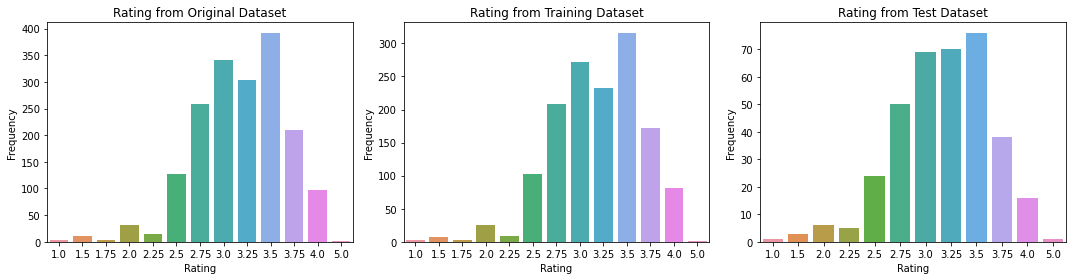

In [54]:
f, axes = plt.subplots(ncols=3, figsize=(15,4))

# Plot histogram using seaborn

sns.countplot(x=Y.values, ax=axes[0])
axes[0].set(xlabel='Rating', ylabel='Frequency', title='Rating from Original Dataset') # Original dataset rating distribution

sns.countplot(x=Y_train.values, ax=axes[1])
axes[1].set(xlabel='Rating', ylabel='Frequency', title='Rating from Training Dataset') # Training dataset rating distribution

sns.countplot(x=Y_test.values, ax=axes[2])
axes[2].set(xlabel='Rating', ylabel='Frequency', title='Rating from Test Dataset') # Original dataset rating distribution
plt.tight_layout() 
plt.show()

#### Distributions are very similar. We can move on.

#### To model our data, I have chosen <b> XGBoost </b>: It is a popular machine learning algorithm used for both classification and regression tasks. XGBoost is known for its speed and performance, often outperforming other algorithms in many predictive modeling competitions. Overall, XGBoost is a powerful and versatile algorithm that has gained popularity for its ability to handle large-scale datasets, effectively handle missing values, and deliver highly accurate predictions across various machine learning tasks. However, it is often that XGBoost overfits the data, which is something we will have to be aware. 

In [55]:
%%time
regrXGB = xgb.XGBRegressor(
    booster='gbtree',
    n_estimators=10000,
    #early_stopping_rounds=50,
    objective='reg:squarederror',#'reg:linear',
    max_depth=5,
    learning_rate=0.0008,
)


CPU times: user 38 µs, sys: 1 µs, total: 39 µs
Wall time: 43.2 µs


In [56]:
%%time
regrXGB.fit(X_train, Y_train,
        eval_set=[(X_train._get_numeric_data(), Y_train._get_numeric_data())]
        ,verbose=2000)

[0]	validation_0-rmse:2.72961
[2000]	validation_0-rmse:0.61147
[4000]	validation_0-rmse:0.24516
[6000]	validation_0-rmse:0.19630
[8000]	validation_0-rmse:0.18030
[9999]	validation_0-rmse:0.16989
CPU times: user 1min 40s, sys: 4.2 s, total: 1min 44s
Wall time: 18 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.0008, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [57]:
def smape(predict, data):
    """
    This function computes the SMAPE (Symmetric Mean Absolute Percentage Error)
    """
    return 100/len(data) * np.sum(np.abs(predict - data) / (np.abs(data) + np.abs(predict)))

In [58]:
def print_metrics(X, Y,model=regrXGB):
    """
    This function simply prints the metrics that evaluate the model
    """
    print("\tSMAPE:", smape(model.predict(X), Y) )
    print("\tMean absolute error (MAE):", mean_absolute_error(Y, model.predict(X)))
    print("\tRoot Mean squared error (RMSE):",  np.sqrt(mean_squared_error(Y, model.predict(X))))
    print("\tR2 score:", r2_score(Y, model.predict(X)))
    
    return

#### SMAPE, MAE, RMSE, and R2 are metrics commonly used to evaluate the performance of regression models. Here's a brief summary of what each of these metrics tells us: 

- <b> SMAPE (Symmetric Mean Absolute Percentage Error)</b> measures the percentage difference between actual and predicted values. It is a symmetric version of Mean Absolute Percentage Error (MAPE) that is not affected by the direction of the error. SMAPE is typically used when the scale of the variables being predicted is important.

- <b>MAE (Mean Absolute Error)</b> measures the average absolute difference between the predicted and actual values. It is less sensitive to outliers than other error metrics and is often used when the model needs to be optimized for accuracy rather than precision.

- <b>RMSE (Root Mean Squared Error)</b> measures the standard deviation of the residuals (the difference between the predicted and actual values). It is a popular metric because it penalizes large errors more than small errors and is more interpretable than the variance of the residuals.

- <b>R2 (Coefficient of Determination)</b> measures the proportion of variance in the dependent variable that is explained by the independent variable(s). It ranges from 0 to 1, with 1 indicating a perfect fit and 0 indicating that the model does not explain any of the variation in the dependent variable.


##### In general, a good model will have low values of SMAPE, MAE, and RMSE, and a high value of R2. However, the ideal values of these metrics depend on the specific problem being solved and the underlying data. It is also important to use multiple metrics to evaluate model performance and to compare the results with other models and benchmarks.

In [59]:
print_metrics(X_train,Y_train)

	SMAPE: 1.8560236585683219
	Mean absolute error (MAE): 0.11260000726306671
	Root Mean squared error (RMSE): 0.1698931227662513
	R2 score: 0.8732138458517436


In [60]:
print_metrics(X_test,Y_test)

	SMAPE: 3.195481081177065
	Mean absolute error (MAE): 0.18899353799049567
	Root Mean squared error (RMSE): 0.29458889240621494
	R2 score: 0.6245823522024476


#### Based on these metrics, the model seems to perform reasonably well on the training dataset, with an R2 score of 0.87. However, the performance on the test dataset is slightly lower, with an R2 score of 0.62. This suggests that the model may be overfitting the training data to some extent.

#### To improve the model's performance, I could consider adjusting the hyperparameters of the XGBoost model, increasing the regularization strength, or trying different feature engineering techniques. Additionally, I may explore other regression algorithms or ensemble models to see if they provide better performance on your dataset.

#### I will first try adjusting the hyperparameters and see if I can fine tune the model. Basically, I am going to create several models and store their parameters. In this case, I am selecting the "best" model as the one that has the R2 values for both training and test data the closest. There are several ways to look into this, like take the "best model" as the one that has the highest R2 for the test, or even a balance between R2s from both dataset. But this was the way I think the model is performing satisfactorily and not overfitting (too much). 

In [61]:
# Here I am computing the feature importance for our model
feature_importance= pd.DataFrame(data=regrXGB.feature_importances_,
                 index  = regrXGB.get_booster().feature_names,
                 columns= ['importance'])
feature_importance.sort_values('importance', ascending=False).head(10)

,importance
NSpecific_Bean_Origin_or_Bar_Name,0.525215
NCompany,0.174922
NBroad_Bean_Origin,0.077036
Time_Difference,0.063122
Cocoa_Percent,0.060187
NCompany_Location,0.053401
NBean_Type,0.046116


<Figure size 720x360 with 0 Axes>

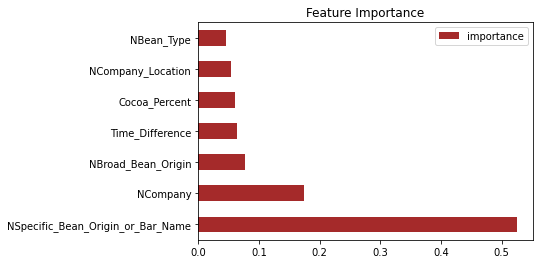

In [62]:
# Plotting these results
plt.figure(figsize=(10, 5))
fig1 = feature_importance.sort_values('importance', ascending=False).head(10)
fig1.plot(kind='barh', title='Feature Importance',color='brown')
plt.legend(loc='upper right')
plt.show()

#### This is an intersting result, the model is giving a lot of importance to the features Specific_Bean_Origin and NCompany, which are the features with a huge amount of classes. 

#### Let's first do some Hyperparameter tunning. Here I am also including L1 and L2 regularization terms to penalize the model and reduce possible overfittings, which are very common to occur when using XGBoost.

In [63]:
%%time
# Define the range of regularization parameters to test
gamma_values = [0, 0.1, 0.5, 1]
reg_alpha_values = [0, 0.1, 0.01, 0.001]
reg_lambda_values = [0, 0.1, 0.01, 0.001]

# Create an empty dictionary to store the models and their corresponding R2 scores
models = {}

# Iterate over all combinations of regularization parameters
for gamma in gamma_values:
    for reg_alpha in reg_alpha_values:
        for reg_lambda in reg_lambda_values:
            # Create the XGBoost model with the current regularization parameters
            regrXGB = xgb.XGBRegressor(
                booster='gbtree',
                n_estimators=10000,
                #early_stopping_rounds=50,
                objective='reg:squarederror',#'reg:linear',
                max_depth=5,
                learning_rate=0.0008,
                gamma=gamma,
                reg_alpha=reg_alpha,
                reg_lambda=reg_lambda
            )
            
            # Fit the model on the training dataset
            regrXGB.fit(X_train, Y_train)
            
            # Make predictions on the test dataset
            y_pred_train = regrXGB.predict(X_train)
            y_pred_test = regrXGB.predict(X_test)
            
            # Calculate the R2 score
            r2_train = r2_score(Y_train, y_pred_train)
            r2_test = r2_score(Y_test, y_pred_test)
            
            # Store the model and its R2 score in the dictionary
            models[(gamma, reg_alpha, reg_lambda)] = [r2_train,r2_test]

CPU times: user 1h 29min 54s, sys: 2min 33s, total: 1h 32min 27s
Wall time: 15min 19s


In [64]:
models

{(0, 0, 0): [0.8957551261162529, 0.6150208032807292],
 (0, 0, 0.1): [0.8929985817912913, 0.6171821853522681],
 (0, 0, 0.01): [0.896574190622332, 0.6156851342991356],
 (0, 0, 0.001): [0.8958297683457151, 0.6181173838570966],
 (0, 0.1, 0): [0.8936399994608295, 0.623313083840779],
 (0, 0.1, 0.1): [0.8907535451014509, 0.6234586418897532],
 (0, 0.1, 0.01): [0.8930444375149997, 0.6200768530893319],
 (0, 0.1, 0.001): [0.8934287242018114, 0.6180719079550993],
 (0, 0.01, 0): [0.8951823734981834, 0.6198015468169066],
 (0, 0.01, 0.1): [0.8924188760074919, 0.6163468854298828],
 (0, 0.01, 0.01): [0.8943464888380135, 0.6217778859991535],
 (0, 0.01, 0.001): [0.8963928220413594, 0.6192699427746597],
 (0, 0.001, 0): [0.8962925810057865, 0.6148315563180076],
 (0, 0.001, 0.1): [0.8931744907152857, 0.6186780030188219],
 (0, 0.001, 0.01): [0.8969249707657168, 0.6133961832796591],
 (0, 0.001, 0.001): [0.8959392425464361, 0.616390776719349],
 (0.1, 0, 0): [0.8678290123663012, 0.6302042907698482],
 (0.1, 0, 0

In [65]:
# Initialize variables to track the minimum subtraction value and its corresponding key
min_subtraction = float('inf')
min_key = None

# Iterate over the dictionary items and find the key with the minimum subtraction
for key, value in models.items():
    subtraction = abs(value[0] - value[1])
    if subtraction < min_subtraction:
        min_subtraction = subtraction
        min_key = key

print("Minimum Subtraction Value:", min_subtraction)
print("Key with Minimum Subtraction:", min_key)
best_model_params = min_key

Minimum Subtraction Value: 0.09853857497457663
Key with Minimum Subtraction: (1, 0.1, 0.1)


In [66]:
# Running now with the best model selected above.
best_model = xgb.XGBRegressor(
    booster='gbtree',
    n_estimators=10000,
    #early_stopping_rounds=50,
    objective='reg:squarederror',
    max_depth=7,
    learning_rate=0.0008,
    gamma=best_model_params[0],
    reg_alpha=best_model_params[1],
    reg_lambda=best_model_params[2]
)

# Fit the best model on the training dataset
best_model.fit(X_train, Y_train)

# Make predictions on the test dataset using the best model
y_pred_best_train = best_model.predict(X_train)
y_pred_best_test = best_model.predict(X_test)

# Calculate the R2 score for the best model
r2_best_train = r2_score(Y_train, y_pred_best_train)
r2_best_test = r2_score(Y_test, y_pred_best_test)

In [67]:
print_metrics(X_train, Y_train,model=best_model)

	SMAPE: 2.8882331950805824
	Mean absolute error (MAE): 0.1753917796366062
	Root Mean squared error (RMSE): 0.24689050317407057
	R2 score: 0.7322502957198613


In [68]:
print_metrics(X_test, Y_test,model=best_model)

	SMAPE: 3.4619608864739164
	Mean absolute error (MAE): 0.20595011007154884
	Root Mean squared error (RMSE): 0.29631089332424765
	R2 score: 0.6201805638156466


#### I believe we have handled overfitting problem now. We could stop here, the results are not bad but actually satisfactory, but let's take a look at the feature importance in the model and see if there is room for improvement. 

In [69]:
# Here I am computing the feature importance
feature_importance= pd.DataFrame(data=best_model.feature_importances_,
                 index  = best_model.get_booster().feature_names,
                 columns= ['importance'])
feature_importance.sort_values('importance', ascending=False).head(10)

,importance
NSpecific_Bean_Origin_or_Bar_Name,0.390272
NCompany,0.215905
Cocoa_Percent,0.099727
NBroad_Bean_Origin,0.095968
NCompany_Location,0.076564
Time_Difference,0.067530
NBean_Type,0.054034


<Figure size 720x360 with 0 Axes>

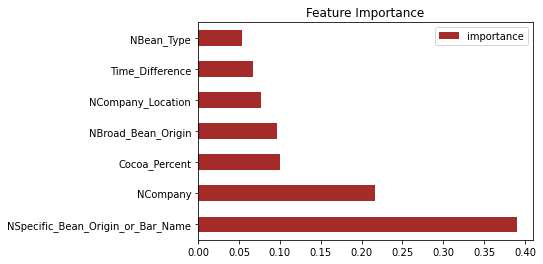

In [70]:
plt.figure(figsize=(10, 5))
fig1 = feature_importance.sort_values('importance', ascending=False).head(10)
fig1.plot(kind='barh', title='Feature Importance',color='brown')
plt.legend(loc='upper right')
plt.show()

#### The model is still giving a lot of importance to the same features, as expected.

#### However, if you recall from cell 18:
df.nunique()
- Company = 416; Specific_Bean_Origin_or_Bar_Name = 1039; REF = 440; Review_Date = 12; Cocoa_Percent = 45;
- Company_Location = 60; Rating = 13; Bean_Type = 41; Broad_Bean_Origin = 100

#### We have TOO many classes for the Specific_Bean_Origin_or_Bar_Name and Company features, do remember that the amount of rows are around 1700. In a way, the model can not perform very well under these circustances due to this amount of classes, simply because to train and validate it is almost impossible, given taht we have more than half of classes for the whole dataset. Therefore, we may perform some engineering to reduce the amount of classes in these two features.

#### BUT, before tackling the classes modifcation, let's try different models and see what we get.

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


def models_ensemble(X_train,Y_train,X_test,Y_test):
    """
    This function computes different models, so it basically does a model ensemble. 
    """
    # Create a list of regression models
    models_ = [LinearRegression(),
               DecisionTreeRegressor(),
               RandomForestRegressor(),
               GradientBoostingRegressor()]

    # Train and evaluate each model
    for model in models_:
        model.fit(X_train, Y_train)  # Train the model
        y_pred_train = model.predict(X_train)  # Make predictions on the train set
        y_pred = model.predict(X_test)  # Make predictions on the test set
    
        # Calculate evaluation metrics
        r2_train = r2_score(Y_train, y_pred_train)
        r2_test = r2_score(Y_test, y_pred)
        mae = mean_absolute_error(Y_test, y_pred)
        rmse = mean_squared_error(Y_test, y_pred, squared=False)
    
        # Print the performance metrics
        print(f"Model: {model.__class__.__name__}")
        print(f"Mean absolute error (MAE): {mae}")
        print(f"Root Mean squared error (RMSE): {rmse}")
        print(f"R2 score train data: {r2_train}")
        print(f"R2 score test data: {r2_test}")
        print()

    return

models_ensemble(X_train,Y_train,X_test,Y_test)

Model: LinearRegression
Mean absolute error (MAE): 0.3078194366873222
Root Mean squared error (RMSE): 0.3930431188408492
R2 score train data: 0.3191725737979273
R2 score test data: 0.33171402979637843

Model: DecisionTreeRegressor
Mean absolute error (MAE): 0.21727019498607242
Root Mean squared error (RMSE): 0.38058743628420216
R2 score train data: 0.9996176370502243
R2 score test data: 0.3733993454728539

Model: RandomForestRegressor
Mean absolute error (MAE): 0.18174326833797588
Root Mean squared error (RMSE): 0.28761041875939386
R2 score train data: 0.95358188760476
R2 score test data: 0.6421581108104202

Model: GradientBoostingRegressor
Mean absolute error (MAE): 0.19400043341255022
Root Mean squared error (RMSE): 0.29140491288713427
R2 score train data: 0.7937982241690928
R2 score test data: 0.6326536847227824



#### Results from other techniques that are not XGBoost:
- Linear Regression is not able to even model the training set, which is undertandable since it is not a linear problem, and it requires scaled data which is not our case;
- DecisionTreeRegressor is clearly overfitting much more than our XGBoost;
- RandomForestRegressor is also overfitting;
- GradientBoostingRegressor has satisfactorily results but they are very comparable to XGBoost, so I think we can stick with XGBoost.

### <b>6. Dealing with classes within features: Grouping or Aggregation</b>
#### With the goal of trying to reduce the number of classes in the features with high importance to our model, I can think of three possibilities:
1. <b>Specific_Bean_Origin_or_Bar_Name</b> --> Select the highest counted and put the other classes as "Others";
2. <b>Company</b> --> also selected the companies that most appear in the ratings and change the others to "Others";
3. <b>Ratings</b> --> I can change the ratings by rounding them to 1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5 and 5.0. Like it would be done when you rate something on google, for example. This could make the model perform better.

#### Given that 3. may not change very much the output, I will first perform 1 and 2 and see if the model performs better. The 3rd is in included in the Appendix part.

In [72]:
df

,Company,Specific_Bean_Origin_or_Bar_Name,Cocoa_Percent,Company_Location,Rating,Bean_Type,Broad_Bean_Origin,Time_Difference
0,A. Morin,Agua Grande,63.0,France,3.75,Unknown,Sao Tome,16.000000
1,A. Morin,Kpime,70.0,France,2.75,Unknown,Togo,15.000684
2,A. Morin,Atsane,70.0,France,3.00,Unknown,Togo,15.000684
3,A. Morin,Akata,70.0,France,3.50,Unknown,Togo,15.000684
4,A. Morin,Quilla,70.0,France,3.50,Unknown,Peru,15.000684
...,...,...,...,...,...,...,...,...
1790,Zotter,Peru,70.0,Austria,3.75,Unknown,Peru,11.000684
1791,Zotter,Congo,65.0,Austria,3.00,Forastero,Congo,11.000684
1792,Zotter,Kerala State,65.0,Austria,3.50,Forastero,India,11.000684
1793,Zotter,Kerala State,62.0,Austria,3.25,Unknown,India,11.000684


In [88]:
df_new = df.copy()

In [89]:
top_bean_origins = df_new.Specific_Bean_Origin_or_Bar_Name.value_counts().head(170)

In [90]:
top_bean_origins

Madagascar                57
Peru                      45
Ecuador                   42
Dominican Republic        37
Venezuela                 21
                          ..
Colombian                  2
Haleiwa E, O'ahu, 2014     2
Virunga                    2
Principe                   2
Blend No. 1                2
Name: Specific_Bean_Origin_or_Bar_Name, Length: 170, dtype: int64

In [91]:
df_new.loc[df_new.Specific_Bean_Origin_or_Bar_Name.isin(top_bean_origins.index),:].shape[0] / df_new.shape[0] * 100

50.9192200557103

Important: 51% of the Bean Origin correspond 170 of the classes (out of 1039). Therefore, we can let these 170 classes and then classify the others as "Others".

In [92]:
def class_reduction(a):
    """
    This function simply reduce the amount of classes by grouping the classes on top_bean_origins or others, within the
    feature Bean_Origins
    """
    if a in top_bean_origins:
        return a
    else:
        return "Others"

In [93]:
df_new['Specific_Bean_Origin_cleaned'] = df_new['Specific_Bean_Origin_or_Bar_Name'].apply(class_reduction)
df_new = df_new.drop(['Specific_Bean_Origin_or_Bar_Name'],axis=1)

In [94]:
df_new

,Company,Cocoa_Percent,Company_Location,Rating,Bean_Type,Broad_Bean_Origin,Time_Difference,Specific_Bean_Origin_cleaned
0,A. Morin,63.0,France,3.75,Unknown,Sao Tome,16.000000,Others
1,A. Morin,70.0,France,2.75,Unknown,Togo,15.000684,Others
2,A. Morin,70.0,France,3.00,Unknown,Togo,15.000684,Others
3,A. Morin,70.0,France,3.50,Unknown,Togo,15.000684,Others
4,A. Morin,70.0,France,3.50,Unknown,Peru,15.000684,Others
...,...,...,...,...,...,...,...,...
1790,Zotter,70.0,Austria,3.75,Unknown,Peru,11.000684,Peru
1791,Zotter,65.0,Austria,3.00,Forastero,Congo,11.000684,Congo
1792,Zotter,65.0,Austria,3.50,Forastero,India,11.000684,Others
1793,Zotter,62.0,Austria,3.25,Unknown,India,11.000684,Others


In [95]:
# How many classes do we have now?
df_new['Specific_Bean_Origin_cleaned'].value_counts()

Others                        881
Madagascar                     57
Peru                           45
Ecuador                        42
Dominican Republic             37
                             ... 
Brazilian                       2
Maranon, Cajamarca              2
Sierra Nevada                   2
Akesson's E., Sambirano V.      2
Blend No. 1                     2
Name: Specific_Bean_Origin_cleaned, Length: 171, dtype: int64

#### Reducing the classes on the Company features

In [96]:
top_company=df_new.Company.value_counts().head(150)
top_company

Soma              47
Bonnat            27
Fresco            26
Pralus            25
A. Morin          23
                  ..
Dormouse           4
Silvio Bessone     4
Cacao Atlanta      4
Mars               4
Belcolade          4
Name: Company, Length: 150, dtype: int64

In [97]:
df_new.loc[df_new.Company.isin(top_company.index),:].shape[0] / df_new.shape[0] * 100

72.14484679665738

#### 72% of the companies are on 150 classes.

In [98]:
def class_reduction_company(a):
    """
    This function simply reduce the amount of classes by grouping the classes on top_company or others, within the
    feature Company
    """
    if a in top_company:
        return a
    else:
        return "Others"

#### Here we see that 72% ratings are concentrated on 97 classes. So, we can reduce it as well.

In [99]:
df_new['Company_cleaned'] = df_new['Company'].apply(class_reduction_company)
df_new = df_new.drop(['Company'],axis=1)
#df_new = time_diff(df_new)
df_new

,Cocoa_Percent,Company_Location,Rating,Bean_Type,Broad_Bean_Origin,Time_Difference,Specific_Bean_Origin_cleaned,Company_cleaned
0,63.0,France,3.75,Unknown,Sao Tome,16.000000,Others,A. Morin
1,70.0,France,2.75,Unknown,Togo,15.000684,Others,A. Morin
2,70.0,France,3.00,Unknown,Togo,15.000684,Others,A. Morin
3,70.0,France,3.50,Unknown,Togo,15.000684,Others,A. Morin
4,70.0,France,3.50,Unknown,Peru,15.000684,Others,A. Morin
...,...,...,...,...,...,...,...,...
1790,70.0,Austria,3.75,Unknown,Peru,11.000684,Peru,Zotter
1791,65.0,Austria,3.00,Forastero,Congo,11.000684,Congo,Zotter
1792,65.0,Austria,3.50,Forastero,India,11.000684,Others,Zotter
1793,62.0,Austria,3.25,Unknown,India,11.000684,Others,Zotter


In [100]:
df_new['Company_cleaned'].nunique()

151

In [101]:
df_new.columns

Index(['Cocoa_Percent', 'Company_Location', 'Rating', 'Bean_Type',
       'Broad_Bean_Origin', 'Time_Difference', 'Specific_Bean_Origin_cleaned',
       'Company_cleaned'],
      dtype='object')

In [102]:
## ENCODING AGAIN

df_encod_new = df_new.copy()

features_new    = ['Company_cleaned','Specific_Bean_Origin_cleaned','Company_Location','Bean_Type','Broad_Bean_Origin']
new_features_new = ['NCompany_cleaned','NSpecific_Bean_Origin_cleaned','NCompany_Location','NBean_Type','NBroad_Bean_Origin']

m = 100 # Just an intial guess
for i in range(len(features_new)):
    df_encod_new[new_features_new[i]]=calc_average_smooth(df_encod_new, by=features_new[i], on='Rating',m=100)
    df_encod_new.drop(features_new[i], axis=1, inplace=True)

In [103]:
df_encod_new

,Cocoa_Percent,Rating,Time_Difference,NCompany_cleaned,NSpecific_Bean_Origin_cleaned,NCompany_Location,NBean_Type,NBroad_Bean_Origin
0,63.0,3.75,16.000000,3.222303,3.225630,3.225950,3.143313,3.184939
1,70.0,2.75,15.000684,3.222303,3.225630,3.225950,3.143313,3.182945
2,70.0,3.00,15.000684,3.222303,3.225630,3.225950,3.143313,3.182945
3,70.0,3.50,15.000684,3.222303,3.225630,3.225950,3.143313,3.182945
4,70.0,3.50,15.000684,3.222303,3.225630,3.225950,3.143313,3.156013
...,...,...,...,...,...,...,...,...
1790,70.0,3.75,11.000684,3.203789,3.104092,3.197169,3.143313,3.156013
1791,65.0,3.00,11.000684,3.203789,3.189640,3.197169,3.146221,3.198576
1792,65.0,3.50,11.000684,3.203789,3.225630,3.197169,3.146221,3.183590
1793,62.0,3.25,11.000684,3.203789,3.225630,3.197169,3.143313,3.183590


### <b>7. Re-modelling</b>

#### Here I am going to use these changes in the classes within the features and check whether it performs better or not. At the end of this section, I will try to check whether the one hot encoding can improve the very first modelling I did as well.

In [104]:
X_new = df_encod_new.drop(["Rating"],axis =1)#,"NContinent","NCompany_cleaned","NBroad_Bean_Origin","NSpecific_Bean_Origin_cleaned"],axis =1)#,"NSpecific_Bean_Origin_or_Bar_Name","NCompany"],axis =1)
Y_new = df_encod_new['Rating']
X_train_v2,X_test_v2,Y_train_v2,Y_test_v2 = train_test_split(X_new,Y_new,test_size=0.2,random_state = 42)

In [105]:
%%time
regrXGB_new = xgb.XGBRegressor(
    booster='gbtree',
    n_estimators=10000,
    #early_stopping_rounds=50,
    objective='reg:squarederror',#'reg:linear',
    max_depth=5,
    learning_rate=0.0008,                
    gamma=0.5,
    reg_alpha=0.1,
    reg_lambda=0
)

CPU times: user 114 µs, sys: 387 µs, total: 501 µs
Wall time: 535 µs


In [106]:
%%time
regrXGB_new.fit(X_train_v2, Y_train_v2,
        eval_set=[(X_train_v2._get_numeric_data(), Y_train_v2._get_numeric_data())]
        ,verbose=2000)

[0]	validation_0-rmse:2.72961
[2000]	validation_0-rmse:0.65348
[4000]	validation_0-rmse:0.35586
[6000]	validation_0-rmse:0.33686
[8000]	validation_0-rmse:0.33577
[9999]	validation_0-rmse:0.33568
CPU times: user 1min 32s, sys: 4.19 s, total: 1min 36s
Wall time: 17.1 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.5, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.0008, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.1, reg_lambda=0, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [107]:
print_metrics(X_train_v2,Y_train_v2,model=regrXGB_new)

	SMAPE: 4.366442387219465
	Mean absolute error (MAE): 0.27035999231683844
	Root Mean squared error (RMSE): 0.3356799117133899
	R2 score: 0.5050390519826176


In [108]:
print_metrics(X_test_v2,Y_test_v2,model=regrXGB_new)

	SMAPE: 5.01112030254188
	Mean absolute error (MAE): 0.3042606424156338
	Root Mean squared error (RMSE): 0.3864976967129074
	R2 score: 0.3537868826742574


#### Result: As we can see, these classes reduction actually did not improve the results, it got worse. Well, it's unfortunate but it is a result anyway.

In [109]:
# Here I am computing the feature importance
feature_importance= pd.DataFrame(data=regrXGB_new.feature_importances_,
                 index  = regrXGB_new.get_booster().feature_names,
                 columns= ['importance'])
feature_importance.sort_values('importance', ascending=False).head(10)

,importance
NCompany_cleaned,0.404659
Cocoa_Percent,0.137940
NSpecific_Bean_Origin_cleaned,0.111910
NBroad_Bean_Origin,0.094347
NBean_Type,0.090669
Time_Difference,0.086552
NCompany_Location,0.073923


<Figure size 720x360 with 0 Axes>

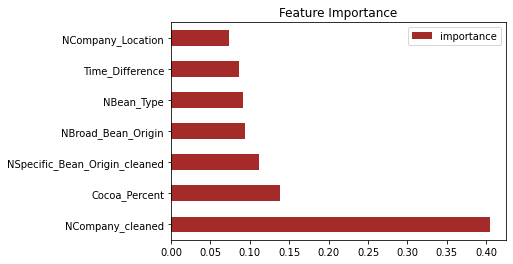

In [110]:
plt.figure(figsize=(10, 5))
fig1 = feature_importance.sort_values('importance', ascending=False).head(10)
fig1.plot(kind='barh', title='Feature Importance',color='brown')
plt.legend(loc='upper right')
plt.show()

In [111]:
# Let's see if other models can perform better
models_ensemble(X_train_v2,Y_train_v2,X_test_v2,Y_test_v2)

Model: LinearRegression
Mean absolute error (MAE): 0.3389005640915459
Root Mean squared error (RMSE): 0.4291257003064197
R2 score train data: 0.20484601413136838
R2 score test data: 0.20338037813357923

Model: DecisionTreeRegressor
Mean absolute error (MAE): 0.38532961931290627
Root Mean squared error (RMSE): 0.5115313728442271
R2 score train data: 0.9865217060204058
R2 score test data: -0.13194805739699578

Model: RandomForestRegressor
Mean absolute error (MAE): 0.312644628487421
Root Mean squared error (RMSE): 0.39036178537336147
R2 score train data: 0.8903434489016536
R2 score test data: 0.34080099916387696

Model: GradientBoostingRegressor
Mean absolute error (MAE): 0.30354710375026844
Root Mean squared error (RMSE): 0.38280482606854394
R2 score train data: 0.5112222374869082
R2 score test data: 0.3660766369902495



#### As expected, no. At this stage, there is no reason to keep these classes reduction.

### <b>8. Conclusions </b>

#### Throughout this notebook, we extensively analyzed and modeled the chocolate bar ratings dataset. The main findings can be summarized as follows:
- Initially, we identified a significant number of missing values in the "Bean_Type" feature, which we replaced with a new class called "Unknown."We observed that two features, namely "Specific Bar Origin" and "Company," had a large number of distinct classes compared to the available data (around 1800 samples).
- A correlation was discovered between two features, "REF" and "Review_Date." To address this, we performed data engineering and created a new feature that captured information from both, avoiding the use of correlated features in our model.
- As many features contained categorical data, encoding was necessary to prepare them for modeling. We chose to use a smoothed version of Target Encoding as our encoding method.
- For modeling, we selected XGBoost and split the dataset into a training set (80% of the data). Given the limited amount of data, we decided not to use cross-validation to preserve as much data as possible for training and testing. Model evaluation was performed using SMAPE, MAE, RMSE, and R2 score on both the training and test sets. Initially, the model showed good performance on the first three metrics for both sets. However, the R2 score on the test set was lower than the training set, indicating potential overfitting or issues with reproducibility. To address this, we conducted hyperparameter tuning and selected the model with the lowest R2 score for both datasets. At this stage, we achieved satisfactory results considering the available dataset, but there was room for improvement and further exploration.
    - We analyzed the feature importance and found that the model attributed significant importance to two features: "Specific_Bean_Origin_or_Bar_Name" and "Company," which had a large number of classes. This raised several questions:
        - What would happen if we dropped these features?
        - How would the model perform if we grouped their classes?
        - How would different encodings affect the model's performance?
- Before addressing these questions, we conducted model ensembling, exploring different models to assess their performance compared to XGBoost. Ultimately, only one model performed as well as XGBoost, reaffirming its suitability for the task.
- In an effort to improve the best model and answer the aforementioned questions, we attempted to aggregate classes within the "Specific_Bean_Origin_or_Bar_Name" and "Company" features and retrained the model. However, these modifications did not lead to improvement.
- To conclude, it is very difficult for the model to get trained in a dataset with too many classes but not much data, specially because there will be classes that can not be reasonably split into training and test sets. That's why it is very unlikely we can improve the model we got, I believe there are only two ways to do that:
    1. Aggregate more and better the classes: but this would require a reasonably significant amount of time to study all the classes in the features; 
    2. Synthetic Data Creation: by analyzing the statistical distribution of the features, we could create more data and increase the amount of data to feed the model. 
    Both would require more time to work on and it would go beyond this assignment, I believe.
- Therefore, I believe our model satisfactorily reproduces the data given the complexity and amount of data and features we have available.

### <b>9. Appendix </b>: extra tests

#### In this section, I performed several tests to see whether we can improve our best model or not, they are:
- class reduction on Ratings
- Model with One Hot Encoding
- Encoding before splitting
- Model with Feature Hash

#### Results: None of these tests could improve our model. It is unfortunate but a result anyway and that's why I kept it.

In [112]:
test=df_encod.copy()

In [113]:
test

,Cocoa_Percent,Rating,Time_Difference,NCompany,NSpecific_Bean_Origin_or_Bar_Name,NCompany_Location,NBean_Type,NBroad_Bean_Origin
0,63.0,3.75,16.000000,3.222303,3.191518,3.225950,3.143313,3.184939
1,70.0,2.75,15.000684,3.222303,3.181617,3.225950,3.143313,3.182945
2,70.0,3.00,15.000684,3.222303,3.184092,3.225950,3.143313,3.182945
3,70.0,3.50,15.000684,3.222303,3.189043,3.225950,3.143313,3.182945
4,70.0,3.50,15.000684,3.222303,3.189043,3.225950,3.143313,3.156013
...,...,...,...,...,...,...,...,...
1790,70.0,3.75,11.000684,3.203789,3.104092,3.197169,3.143313,3.156013
1791,65.0,3.00,11.000684,3.203789,3.189640,3.197169,3.146221,3.198576
1792,65.0,3.50,11.000684,3.203789,3.189640,3.197169,3.146221,3.183590
1793,62.0,3.25,11.000684,3.203789,3.189640,3.197169,3.143313,3.183590


#### Let's see if reducing the amount of classes on the Rating will help the modelling.

In [114]:
def rating_to_stars(rating):
    """
    This function groups the ratings in 1,2,3,4,5 like when you give stars on a review in Google, for example.
    """
    if (rating == 0.0 ):
        return 0
    elif (rating > 0 ) and (rating <= 1.49 ):
        return 1
    elif (rating >= 1.50 ) and (rating <= 2.49 ):
        return 2
    elif (rating >= 2.50 ) and (rating <= 3.49 ):
        return 3
    elif (rating >= 3.50 ) and (rating <= 4.49 ):
        return 4
    else:
        return 5

In [115]:
test['Rating'] = test['Rating'].apply(rating_to_stars)

In [116]:
test['Rating'].unique()

array([4, 3, 5, 2, 1])

In [117]:
X_new_ = test.drop(["Rating"],axis =1)#,"NSpecific_Bean_Origin_or_Bar_Name","NCompany"],axis =1)
Y_new_ = test['Rating']
X_train_v3,X_test_v3,Y_train_v3,Y_test_v3 = train_test_split(X_new_,Y_new_,test_size=0.2,random_state = 42)

In [118]:
%%time
regrXGB_new = xgb.XGBRegressor(
    booster='gbtree',
    n_estimators=10000,
    #early_stopping_rounds=50,
    objective='reg:squarederror',#'reg:linear',
    max_depth=5,
    learning_rate=0.0008,                
    gamma=0.5,
    reg_alpha=0.1,
    reg_lambda=0
    
)

CPU times: user 82 µs, sys: 2 µs, total: 84 µs
Wall time: 91.1 µs


In [119]:
%%time
regrXGB_new.fit(X_train_v3, Y_train_v3,
        eval_set=[(X_train_v3._get_numeric_data(), Y_train_v3._get_numeric_data())]
        ,verbose=2000)

[0]	validation_0-rmse:2.91377
[2000]	validation_0-rmse:0.65510
[4000]	validation_0-rmse:0.29660
[6000]	validation_0-rmse:0.26952
[8000]	validation_0-rmse:0.26775
[9999]	validation_0-rmse:0.26771
CPU times: user 1min 36s, sys: 3.09 s, total: 1min 39s
Wall time: 15.9 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.5, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.0008, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.1, reg_lambda=0, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [120]:
print_metrics(X_train_v3,Y_train_v3,model=regrXGB_new)

	SMAPE: 2.570075870144309
	Mean absolute error (MAE): 0.16755521795543787
	Root Mean squared error (RMSE): 0.2677116330547972
	R2 score: 0.7671415647932818


In [121]:
print_metrics(X_test_v3,Y_test_v3,model=regrXGB_new)

	SMAPE: 3.6658052206045997
	Mean absolute error (MAE): 0.2345117008453624
	Root Mean squared error (RMSE): 0.3648478922299977
	R2 score: 0.5827042364323947


#### Overfitting yet but still not as good the previous models. Therefore, we can say it did not improve to take this in consideration.

In [122]:
# Here I am computing the feature importance
feature_importance= pd.DataFrame(data=regrXGB_new.feature_importances_,
                 index  = regrXGB_new.get_booster().feature_names,
                 columns= ['importance'])
feature_importance.sort_values('importance', ascending=False).head(10)

,importance
NSpecific_Bean_Origin_or_Bar_Name,0.465055
NCompany,0.173971
Cocoa_Percent,0.093779
Time_Difference,0.077201
NBean_Type,0.071840
NBroad_Bean_Origin,0.067871
NCompany_Location,0.050284


<Figure size 720x360 with 0 Axes>

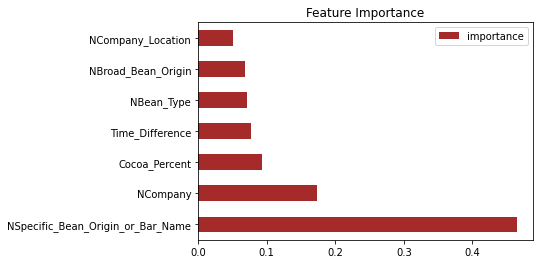

In [123]:
plt.figure(figsize=(10, 5))
fig1 = feature_importance.sort_values('importance', ascending=False).head(10)
fig1.plot(kind='barh', title='Feature Importance',color='brown')
plt.legend(loc='upper right')
plt.show()

### Given that we have tried several stuff, I also want to try the one hot encoding. 

In [124]:
def onehot_encode(data, columns):
    """
    This function computes the one hot encoding for the features
    """
    for column in columns:
        dummies = pd.get_dummies(data[column])
        data = pd.concat([data, dummies], axis=1)
        data.drop(column, axis=1, inplace=True)
    return data

In [125]:
# Applying one hot encoding and dropping duplicates. 
df_encod_onehot =onehot_encode(df,features)
duplicate_columns = df_encod_onehot.columns[df_encod_onehot.columns.duplicated()]
df_encod_onehot.drop(duplicate_columns, axis=1, inplace=True)

In [126]:
df_encod

,Cocoa_Percent,Rating,Time_Difference,NCompany,NSpecific_Bean_Origin_or_Bar_Name,NCompany_Location,NBean_Type,NBroad_Bean_Origin
0,63.0,3.75,16.000000,3.222303,3.191518,3.225950,3.143313,3.184939
1,70.0,2.75,15.000684,3.222303,3.181617,3.225950,3.143313,3.182945
2,70.0,3.00,15.000684,3.222303,3.184092,3.225950,3.143313,3.182945
3,70.0,3.50,15.000684,3.222303,3.189043,3.225950,3.143313,3.182945
4,70.0,3.50,15.000684,3.222303,3.189043,3.225950,3.143313,3.156013
...,...,...,...,...,...,...,...,...
1790,70.0,3.75,11.000684,3.203789,3.104092,3.197169,3.143313,3.156013
1791,65.0,3.00,11.000684,3.203789,3.189640,3.197169,3.146221,3.198576
1792,65.0,3.50,11.000684,3.203789,3.189640,3.197169,3.146221,3.183590
1793,62.0,3.25,11.000684,3.203789,3.189640,3.197169,3.143313,3.183590


In [127]:
# Preparing the splits for the model
X = df_encod_onehot.drop(["Rating"],axis =1)#,"NSpecific_Bean_Origin_or_Bar_Name","NCompany"],axis =1)
Y = df_encod_onehot['Rating']
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train_one,X_test_one,Y_train_one,Y_test_one = train_test_split(X,Y,test_size=0.2,random_state = 42)

In [128]:
X_train_one.shape
# More features than data. :D

(1436, 1516)

In [129]:
%%time
regrXGB_one_hot = xgb.XGBRegressor(
    booster='gbtree',
    n_estimators=10000,
    #early_stopping_rounds=50,
    objective='reg:squarederror',#'reg:linear',
    max_depth=5,
    learning_rate=0.0008,
)


CPU times: user 37 µs, sys: 1e+03 ns, total: 38 µs
Wall time: 42 µs


In [130]:
%%time
regrXGB_one_hot.fit(X_train_one, Y_train_one,
        eval_set=[(X_train_one._get_numeric_data(), Y_train_one._get_numeric_data())]
        ,verbose=2000)

[0]	validation_0-rmse:2.72963
[2000]	validation_0-rmse:0.68848
[4000]	validation_0-rmse:0.41458
[6000]	validation_0-rmse:0.38910
[8000]	validation_0-rmse:0.37966
[9999]	validation_0-rmse:0.37194
CPU times: user 1h 18min 42s, sys: 2min 1s, total: 1h 20min 43s
Wall time: 11min 44s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.0008, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [131]:
print_metrics(X_train_one,Y_train_one,model=regrXGB_one_hot)

	SMAPE: 4.994048523754812
	Mean absolute error (MAE): 0.310589691473581
	Root Mean squared error (RMSE): 0.3719407701982894
	R2 score: 0.3923299914303535


In [132]:
print_metrics(X_test_one,Y_test_one,model=regrXGB_one_hot)

	SMAPE: 5.586913867086988
	Mean absolute error (MAE): 0.3414862215684981
	Root Mean squared error (RMSE): 0.4453999317330355
	R2 score: 0.14181238753303993


In [133]:
# Here I am computing the feature importance
feature_importance= pd.DataFrame(data=regrXGB_one_hot.feature_importances_,
                 index  = regrXGB_one_hot.get_booster().feature_names,
                 columns= ['importance'])
feature_importance.sort_values('importance', ascending=False).head(10)

,importance
Baking,0.027360
Cote d' Or (Kraft),0.017375
Houseblend,0.016676
Ki' Xocolatl,0.013370
Cacao Barry,0.013008
Le Noir Extra Amer,0.012885
Escazu,0.012812
Dark,0.012064
Middlebury,0.011889
Soma,0.011665


In [134]:
test=df_encod.copy()

### Extra testing: encoding the features after splitting the datasets in Train and Test.

In [135]:
test2 = df.copy()
test2

,Company,Specific_Bean_Origin_or_Bar_Name,Cocoa_Percent,Company_Location,Rating,Bean_Type,Broad_Bean_Origin,Time_Difference
0,A. Morin,Agua Grande,63.0,France,3.75,Unknown,Sao Tome,16.000000
1,A. Morin,Kpime,70.0,France,2.75,Unknown,Togo,15.000684
2,A. Morin,Atsane,70.0,France,3.00,Unknown,Togo,15.000684
3,A. Morin,Akata,70.0,France,3.50,Unknown,Togo,15.000684
4,A. Morin,Quilla,70.0,France,3.50,Unknown,Peru,15.000684
...,...,...,...,...,...,...,...,...
1790,Zotter,Peru,70.0,Austria,3.75,Unknown,Peru,11.000684
1791,Zotter,Congo,65.0,Austria,3.00,Forastero,Congo,11.000684
1792,Zotter,Kerala State,65.0,Austria,3.50,Forastero,India,11.000684
1793,Zotter,Kerala State,62.0,Austria,3.25,Unknown,India,11.000684


In [136]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=42)
for train_index,test_index in split.split(df,df['Rating']):
    strat_train_set= test2.loc[train_index]
    strat_test_set= test2.loc[test_index]

In [137]:
strat_train_set=target_encod(strat_train_set,features)

In [138]:
strat_test_set=target_encod(strat_test_set,features)

In [139]:
X_strat_train = strat_train_set.drop(["Rating"],axis =1)
Y_strat_train = strat_train_set['Rating']

X_strat_test = strat_test_set.drop(["Rating"],axis =1)
Y_strat_test = strat_test_set['Rating']

In [140]:
X_strat_train.shape
# More features than data. :D

(1436, 7)

In [141]:
%%time
regrXGB_strat = xgb.XGBRegressor(
    booster='gbtree',
    n_estimators=10000,
    #early_stopping_rounds=50,
    objective='reg:squarederror',#'reg:linear',
    max_depth=5,
    learning_rate=0.0008,
)


CPU times: user 65 µs, sys: 53 µs, total: 118 µs
Wall time: 126 µs


In [142]:
%%time
regrXGB_strat.fit(X_strat_train, Y_strat_train,
        eval_set=[(X_strat_train._get_numeric_data(), Y_strat_train._get_numeric_data())]
        ,verbose=2000)

[0]	validation_0-rmse:2.72664
[2000]	validation_0-rmse:0.61003
[4000]	validation_0-rmse:0.24258
[6000]	validation_0-rmse:0.19428
[8000]	validation_0-rmse:0.17896
[9999]	validation_0-rmse:0.16726
CPU times: user 2min 28s, sys: 6.54 s, total: 2min 34s
Wall time: 25.5 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.0008, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [143]:
print_metrics(X_strat_train,Y_strat_train,model=regrXGB_strat)

	SMAPE: 1.8105026269445745
	Mean absolute error (MAE): 0.10939307191245735
	Root Mean squared error (RMSE): 0.16726428909337152
	R2 score: 0.8774608869162054


In [144]:
print_metrics(X_strat_test,Y_strat_test,model=regrXGB_strat)

	SMAPE: 4.2398811838189605
	Mean absolute error (MAE): 0.26344989402048435
	Root Mean squared error (RMSE): 0.3184445746990383
	R2 score: 0.5568220426644075


#### It's overfitting significantly yet.

In [145]:
# Here I am computing the feature importance
feature_importance= pd.DataFrame(data=regrXGB_strat.feature_importances_,
                 index  = regrXGB_strat.get_booster().feature_names,
                 columns= ['importance'])
feature_importance.sort_values('importance', ascending=False).head(10)

,importance
NSpecific_Bean_Origin_or_Bar_Name,0.497408
NCompany,0.189753
Time_Difference,0.077735
NBroad_Bean_Origin,0.077482
NCompany_Location,0.059274
Cocoa_Percent,0.056411
NBean_Type,0.041937


In [146]:
test2

,Company,Specific_Bean_Origin_or_Bar_Name,Cocoa_Percent,Company_Location,Rating,Bean_Type,Broad_Bean_Origin,Time_Difference
0,A. Morin,Agua Grande,63.0,France,3.75,Unknown,Sao Tome,16.000000
1,A. Morin,Kpime,70.0,France,2.75,Unknown,Togo,15.000684
2,A. Morin,Atsane,70.0,France,3.00,Unknown,Togo,15.000684
3,A. Morin,Akata,70.0,France,3.50,Unknown,Togo,15.000684
4,A. Morin,Quilla,70.0,France,3.50,Unknown,Peru,15.000684
...,...,...,...,...,...,...,...,...
1790,Zotter,Peru,70.0,Austria,3.75,Unknown,Peru,11.000684
1791,Zotter,Congo,65.0,Austria,3.00,Forastero,Congo,11.000684
1792,Zotter,Kerala State,65.0,Austria,3.50,Forastero,India,11.000684
1793,Zotter,Kerala State,62.0,Austria,3.25,Unknown,India,11.000684


### Another type of encoding: Feature Hasher

In [147]:
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import LabelEncoder

# Define the columns to be hashed
columns_to_hash = ['Specific_Bean_Origin_or_Bar_Name', 'Company']

# Create a feature hasher object
hasher = FeatureHasher(n_features=10, input_type='string')

# Perform feature hashing on the selected columns
hashed_features = hasher.transform(test2[columns_to_hash].astype(str))

# Convert the hashed features into a dense matrix
hashed_features = hashed_features.toarray()

# Create a new DataFrame with the hashed features
hashed_df = pd.DataFrame(hashed_features)

# Encode the remaining categorical features
label_encoder = LabelEncoder()
encoded_features = test2.drop(columns_to_hash, axis=1).apply(label_encoder.fit_transform)

# Concatenate the hashed DataFrame with the encoded features
df_processed = pd.concat([hashed_df, encoded_features], axis=1)

# Split the data into train and test sets
X_hash = df_processed.drop('Rating', axis=1)
Y_hash = df_processed['Rating']
X_train_hash, X_test_hash, Y_train_hash, Y_test_hash = train_test_split(X_hash, Y_hash, test_size=0.2, random_state=42)

In [148]:
df_processed

,0,1,2,3,4,5,6,7,8,9,Cocoa_Percent,Company_Location,Rating,Bean_Type,Broad_Bean_Origin,Time_Difference
0,3.0,-4.0,-2.0,7.0,-2.0,3.0,0.0,-3.0,-1.0,3.0,12,18,10,40,67,10
1,1.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,19,18,6,40,77,9
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,18,7,40,77,9
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,18,9,40,77,9
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,18,9,40,55,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,3,10,40,55,5
1791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,3,7,19,12,5
1792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,3,9,19,38,5
1793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,3,8,40,38,5


In [149]:
%%time
regrXGB_hash = xgb.XGBRegressor(
    booster='gbtree',
    n_estimators=10000,
    #early_stopping_rounds=50,
    objective='reg:squarederror',#'reg:linear',
    max_depth=5,
    learning_rate=0.0008,                
    gamma=0.5,
    reg_alpha=0.1,
    reg_lambda=0
    
)
regrXGB_hash.fit(X_train_hash, Y_train_hash,
        eval_set=[(X_train_hash._get_numeric_data(), Y_train_hash._get_numeric_data())]
        ,verbose=2000)

[0]	validation_0-rmse:7.49616
[2000]	validation_0-rmse:2.19019
[4000]	validation_0-rmse:1.56068
[6000]	validation_0-rmse:1.48308
[8000]	validation_0-rmse:1.44667
[9999]	validation_0-rmse:1.41539
CPU times: user 1min 40s, sys: 2.96 s, total: 1min 43s
Wall time: 16.2 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.5, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.0008, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.1, reg_lambda=0, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [150]:
print_metrics(X_train_hash,Y_train_hash,model=regrXGB_hash)

	SMAPE: 7.916801470154462
	Mean absolute error (MAE): 1.1381779034987798
	Root Mean squared error (RMSE): 1.4153857060547257
	R2 score: 0.44103977079164425


In [151]:
print_metrics(X_test_hash,Y_test_hash,model=regrXGB_hash)

	SMAPE: 9.982528415538281
	Mean absolute error (MAE): 1.3915445887610773
	Root Mean squared error (RMSE): 1.779093759332388
	R2 score: 0.10984601173548802


#### Even worst! 

In [152]:
# Here I am computing the feature importance
feature_importance= pd.DataFrame(data=regrXGB_hash.feature_importances_,
                 index  = regrXGB_hash.get_booster().feature_names,
                 columns= ['importance'])
feature_importance.sort_values('importance', ascending=False).head(10)

,importance
Cocoa_Percent,0.287896
Bean_Type,0.186210
Time_Difference,0.180081
Company_Location,0.171179
Broad_Bean_Origin,0.141586
0,0.033047
1,0.000000
2,0.000000
3,0.000000
4,0.000000
